In [11]:
import pandas as pd
from datetime import datetime
import os

from utils import *

In [12]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [13]:
data = pd.read_csv("order_data.csv")
data.head()

,Date,TimeOfDay,MenuItem,Quantity
0,2023-01-01,07:00,Chicken Tikka Masala,2
1,2023-01-01,07:00,Shrimp Scampi,2
2,2023-01-01,07:00,Chicken Alfredo,3
3,2023-01-01,07:00,Caesar Salad,1
4,2023-01-01,07:00,Tiramisu,3


In [14]:
def extract_hour(timestamp):
    time_obj = datetime.strptime(timestamp, '%H:%M')
    return time_obj.hour

# Applying the function to the 'TimeofDay' column to extract hours
data['TimeOfDay'] = data['TimeOfDay'].apply(extract_hour)

In [15]:
# Convert 'Date' column to datetime format and 'TimeOfDay' to timedelta format
data['DateTime'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['TimeOfDay'], unit='h')

In [16]:
# Convert 'Date' column to numeric representation
data['Date'] = pd.to_datetime(data['Date'])
start_date = data['Date'].min()
data['NumericDate'] = (data['Date'] - start_date).dt.days + 1

In [17]:
data = data.groupby(['DateTime', 'Date', 'NumericDate', 'TimeOfDay', 'MenuItem']).agg({'Quantity': 'sum'}).reset_index()
data.head(5)

,DateTime,Date,NumericDate,TimeOfDay,MenuItem,Quantity
0,2023-01-01 07:00:00,2023-01-01,1,7,Beef Stroganoff,5
1,2023-01-01 07:00:00,2023-01-01,1,7,Beef Tacos,4
2,2023-01-01 07:00:00,2023-01-01,1,7,Breakfast Combo,1
3,2023-01-01 07:00:00,2023-01-01,1,7,Caesar Salad,1
4,2023-01-01 07:00:00,2023-01-01,1,7,Chicken Alfredo,3


In [18]:
categorical_columns = ['MenuItem']
data = encodeLabels(data, categorical_columns)
data.head()

,DateTime,Date,NumericDate,TimeOfDay,MenuItem,Quantity
0,2023-01-01 07:00:00,2023-01-01,1,7,1,5
1,2023-01-01 07:00:00,2023-01-01,1,7,2,4
2,2023-01-01 07:00:00,2023-01-01,1,7,3,1
3,2023-01-01 07:00:00,2023-01-01,1,7,4,1
4,2023-01-01 07:00:00,2023-01-01,1,7,5,3


In [19]:
X = data[['NumericDate', 'TimeOfDay', 'MenuItem']]
y = data['Quantity']

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Convert X and y to numpy arrays
X_array = X.values  # Convert DataFrame to numpy array
y_array = y.values
print(X_array.shape[0], X_array.shape[1])
# Reshape X to match the input shape expected by the LSTM layer
X_reshaped = X_array.reshape(X_array.shape[0], 1, X_array.shape[1])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_array, test_size=0.4, random_state=42)

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(units=128, activation='tanh', input_shape=(1, 3)))
model.add(Dense(units=1))  # Output layer for regression (single value prediction)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=25, batch_size=50)

50100 3
Epoch 1/25
602/602 [==============================] - 6s 9ms/step - loss: 59.4191
Epoch 2/25
602/602 [==============================] - 5s 9ms/step - loss: 53.0910
Epoch 3/25
602/602 [==============================] - 5s 9ms/step - loss: 52.1423
Epoch 4/25
602/602 [==============================] - 5s 9ms/step - loss: 51.2705
Epoch 5/25
602/602 [==============================] - 5s 9ms/step - loss: 50.5902
Epoch 6/25
602/602 [==============================] - 5s 9ms/step - loss: 49.9464
Epoch 7/25
602/602 [==============================] - 5s 9ms/step - loss: 49.3608
Epoch 8/25
602/602 [==============================] - 5s 9ms/step - loss: 48.7387
Epoch 9/25
602/602 [==============================] - 5s 9ms/step - loss: 48.1337
Epoch 10/25
602/602 [==============================] - 5s 9ms/step - loss: 47.5391
Epoch 11/25
602/602 [==============================] - 5s 9ms/step - loss: 47.1012
Epoch 12/25
602/602 [==============================] - 5s 9ms/step - loss: 46.7152
Epoch

In [21]:
# Prediction
predictions = model.predict(X_test)

627/627 [==============================] - 2s 3ms/step


In [22]:
evaluate(model, predictions, X_test, y_test, True)

627/627 [==============================] - 3s 5ms/step - loss: 42.5000
Model Performance
Score: 42.49999237060547
Mean Squared Error (MSE): 42.50000076274518
Root Mean Squared Error (RMSE): 6.519202463702533
Mean Absolute Error (MAE): 5.36771992943891
R-squared (R2): 0.24743225322165596


1/1 [==============================] - 0s 27ms/step


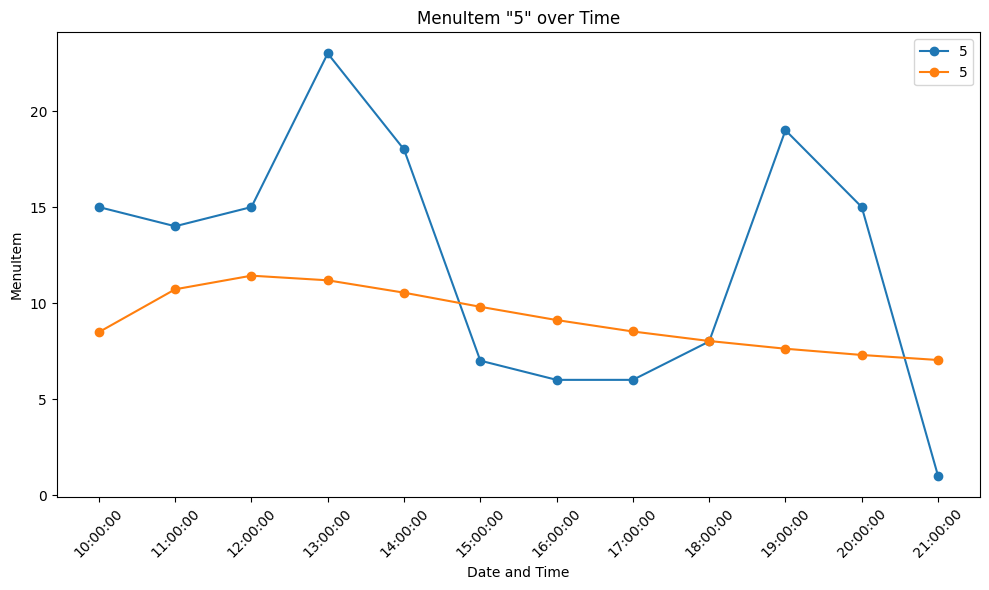

In [23]:
plot_predictions(model, data, '2023-07-20', 5, None, True)

In [24]:
# Save the model
model.save("adam_25_epochs_tanh.keras")